# Ignition

In [54]:
import seaborn as sns
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator , MaxNLocator , MultipleLocator
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import binarize
from sklearn.metrics import mean_squared_error
from scipy.interpolate import make_interp_spline
from numpy.polynomial.polynomial import Polynomial

In [8]:
# Set plotting style and LaTeX options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],  # Use Times New Roman as the default font
})
sns.set_context("paper", font_scale=1.5)

## Results folder

In [76]:
# Define results folder path
results_folder = os.path.join(os.getcwd(), 'results')
os.makedirs(results_folder, exist_ok=True)

## Load data

In [9]:
file_path = 'exp_data/exp_data.csv'
df = pd.read_csv(file_path)
df.head()

,Experiment,Name_tag,Date,N_or_D,TC_corrected,sd_TC,Vel,sd_vel,ignition_type,ign_code,glowing_time,t_ig,max_flame_height_cm,Gas_phase_ign,Gas_phase_ign_loc_cm,Gas_phase_flame_speed_mps,fmc_p,sd_FMC
0,1,N_T1_01,22/04/2024 0:00,N,468.686178,17.810,2.455,0.173,FI,1,3.0,9.5,64.66,0,NaN,NaN,89.453346,0.031743
1,1,N_T1_02,22/04/2024 0:00,N,468.686178,17.810,2.455,0.173,FI,1,3.5,7.8,57.37,0,NaN,NaN,89.453346,0.031743
2,1,N_T1_03,22/04/2024 0:00,N,468.686178,17.810,2.455,0.173,FI,1,4.0,6.5,40.85,0,NaN,NaN,89.453346,0.031743
3,1,N_T2_01,22/04/2024 0:00,N,415.215765,9.935,2.308,0.168,FI,1,12.0,48.0,44.83,1,NaN,NaN,89.453346,0.031743
4,1,N_T2_02,22/04/2024 0:00,N,415.215765,9.935,2.308,0.168,FI,1,23.0,55.0,26.10,0,NaN,NaN,89.453346,0.031743


## Ignition delay times ($t_{ig}$)

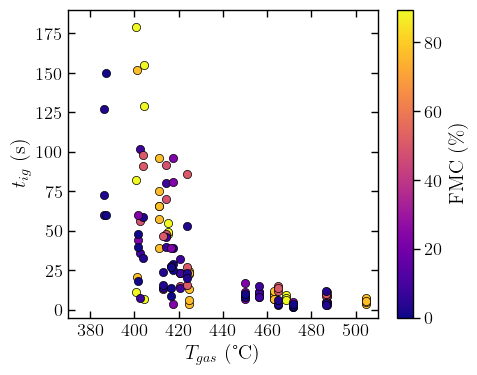

In [77]:
# Set up the color map
norm = mcolors.Normalize(vmin=0, vmax=df['fmc_p'].max())
cmap = plt.cm.plasma

fig, ax = plt.subplots(figsize=(5, 4)) 

for _, row in df.iterrows():
    color = cmap(norm(row['fmc_p']))
    ax.scatter(row['TC_corrected'], row['t_ig'], color=color, marker='o', s=35, edgecolor='k', linewidths=0.5)

ax.xaxis.set_major_locator(MultipleLocator(20))

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'FMC (\%)')

# Add labels and title
ax.set_xlabel('$T_{gas}$ (°C)')
ax.set_ylabel('$t_{ig}$ (s)')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax.set_xlim(370, 510)
ax.set_ylim(-5, 190)

# Save the plot
save_path_pdf = os.path.join(results_folder, "ignition_delay.pdf" )
plt.savefig(save_path_pdf, bbox_inches='tight')  

plt.show()

## Glowing time ($\Delta t$)

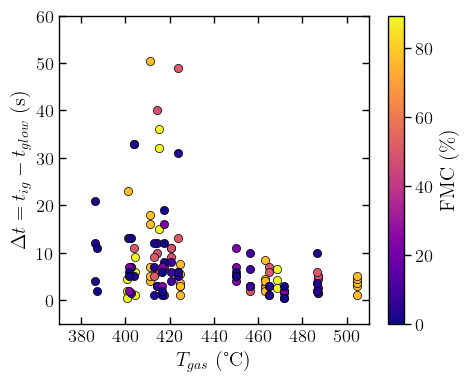

In [78]:
df['Delta_t'] = df['t_ig']-df['glowing_time']

# Set up the color map
norm = mcolors.Normalize(vmin=0, vmax=df['fmc_p'].max())
cmap = plt.cm.plasma

# Create the plot
fig, ax = plt.subplots(figsize=(5, 4)) 

for _, row in df.iterrows():
    color = cmap(norm(row['fmc_p']))
    ax.scatter(row['TC_corrected'], row['Delta_t'], color=color, marker='o', s=35, edgecolor='k', linewidths=0.5)

ax.xaxis.set_major_locator(MultipleLocator(20))

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'FMC (\%)')

ax.set_xlabel('$T_{gas}$ (°C)')
ax.set_ylabel(r'$\Delta t=t_{ig} - t_{glow}$ (s)')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax.set_xlim(370, 510)
ax.set_ylim(-5, 60)

# Save the plot
save_path_pdf = os.path.join(results_folder, "Delta_time.pdf" )
plt.savefig(save_path_pdf, bbox_inches='tight')  

plt.show()

In [38]:
m = df['t_ig'][df['TC_corrected']>=440].mean()
std =df['t_ig'][df['TC_corrected']>=440].std()
print(f't_ig = {m:.2f} ± {std:.2f}')

t_ig = 7.78 ± 3.60


In [39]:
t_threshold = 440 
m_450 = df['Delta_t'][df['TC_corrected']>=t_threshold].mean()
s_450 = df['Delta_t'][df['TC_corrected']>=t_threshold].std()

m_m450 = df['Delta_t'][df['TC_corrected']<t_threshold].mean()
s_m450 = df['Delta_t'][df['TC_corrected']<t_threshold].std()

print(f't_ig >= {t_threshold} = {m_450:.2f} ± {s_450:.2f}')
print(f't_ig < {t_threshold} = {m_m450:.2f} ± {s_m450:.2f}')

t_ig >= 440 = 3.96 ± 2.45
t_ig < 440 = 10.78 ± 10.94


## Logistic Regression

In [42]:
# First: data re-arrangement for analysis
# Step 1: Group by 'Experiment', 'N_or_D', and 'TC2'
grouped = df.groupby(['Experiment', 'N_or_D', 'TC_corrected', 'sd_TC', 'fmc_p'])

# Step 2: Compute average and standard deviation of 't_ig', the average of 'ig_prob', and the average of 'ig_code' within each group
df_2 = grouped.agg({
    't_ig': ['mean', 'std'],
    'ign_code': 'mean'
}, skipna=True)

# Step 3: Flatten the multi-level columns and reset index
df_2.columns = ['t_ig_mean', 't_ig_std', 'ig_prob']
df_2.reset_index(inplace=True)

# Print the new dataframe
df_2.head()

,Experiment,N_or_D,TC_corrected,sd_TC,fmc_p,t_ig_mean,t_ig_std,ig_prob
0,1,N,381.919036,4.349,89.453346,NaN,NaN,0.0
1,1,N,393.363905,4.494,89.453346,NaN,NaN,0.0
2,1,N,400.588275,6.704,89.453346,91.000000,84.072885,1.0
3,1,N,404.500402,9.947,89.453346,97.000000,79.018985,1.0
4,1,N,415.215765,9.935,89.453346,50.666667,3.785939,1.0


Gas temp. value when logistic regression probability is 0.5: 394.64 °C


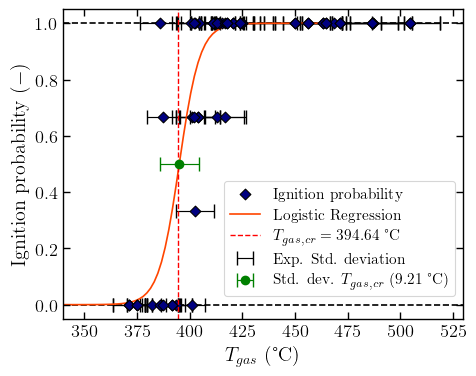

In [79]:
unique_fmc_p = df_2['fmc_p'].unique()
TC_mine = []

for idx, fmc_p in enumerate(unique_fmc_p):
    subset = df_2[df_2['fmc_p'] == fmc_p]
    
    X = subset[['TC_corrected']]  
    y = binarize(subset[['ig_prob']], threshold=0.5).ravel()  # Convert 'ig_prob' to binary labels (0 or 1)
    
    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X, y)
    
    # Predict probabilities for the 'TC2' values
    X_pred = pd.DataFrame(np.linspace(300, max(subset['TC_corrected']), 100),columns=['TC_corrected'])
    y_pred_proba = model.predict_proba(X_pred)[:, 1]
    
    # Find 'TC' value when logistic regression probability is 0.5
    threshold = 0.5
    log_odds_threshold = np.log(threshold / (1 - threshold))
    TC2_threshold = (log_odds_threshold - model.intercept_) / model.coef_[0][0]
    TC2_threshold_value = TC2_threshold[0]
    TC_mine.append(TC2_threshold_value)
    
# Calculate mean and standard deviation of critical gas temperatures
mean_TC = np.mean(TC_mine)
std_TC = np.std(TC_mine)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(5, 4))  

X = df_2[['TC_corrected']]  # Features
y = binarize(df_2[['ig_prob']], threshold=0.5).ravel()  # Convert 'ig_prob' to binary labels (0 or 1)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Predict probabilities for the 'TC' values
X_pred = pd.DataFrame(np.linspace(300, max(subset['TC_corrected']), 100),columns=['TC_corrected'])
y_pred_proba = model.predict_proba(X_pred)[:, 1]

# Find 'TC' value when logistic regression probability is 0.5
threshold = 0.5
log_odds_threshold = np.log(threshold / (1 - threshold))
TC_threshold = (log_odds_threshold - model.intercept_) / model.coef_[0][0]
print(f'Gas temp. value when logistic regression probability is 0.5: {TC2_threshold[0]:.2f} °C')

z = TC2_threshold[0]
# Plotting Logistic regression - Ignition probability
ax.scatter(df_2['TC_corrected'], df_2['ig_prob'], color = 'navy' , marker = 'D' , edgecolor = 'k', s=30,  label='Ignition probability')
ax.errorbar(df_2['TC_corrected'], df_2['ig_prob'], xerr=df_2['sd_TC'], linestyle='None', lw=0.85, color='black', capsize=5, zorder=0, label = 'Exp. Std. deviation')
ax.errorbar(TC_threshold[0], 0.5, xerr=std_TC2, fmt='o', linestyle='None', markersize=6 , lw=0.85, color='green', 
            capsize=5, label=f'Std. dev. $T_{{gas,cr}}$ ({std_TC2:.2f}$~$°C)')

# Adding logistic regression line
ax.plot(X_pred, y_pred_proba, color='orangered', label='Logistic Regression',zorder=0)
ax.axvline(x=TC2_threshold, color='red',  linestyle='--' , linewidth = 1, label = f'$T_{{gas,cr}}={TC2_threshold[0]:.2f}~$°C')
ax.set_xticks(range(350, 526, 25))
ax.set_xlim(340,None)

ax.set_xlabel('$T_{gas}$ (°C)')
ax.set_ylabel(r'Ignition probability ($-$)')
ax.legend(loc='lower right', fontsize=11, bbox_to_anchor=(1, 0.05))  
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)

ax.axhline(y = 0, color = 'k', linestyle = '--',zorder = -1) 
ax.axhline(y = 1, color = 'k', linestyle = '--',zorder = -1) 

plt.tight_layout()
save_path_pdf = os.path.join(results_folder, "log_regression.pdf" )
plt.savefig(save_path_pdf, bbox_inches='tight')  
plt.show()

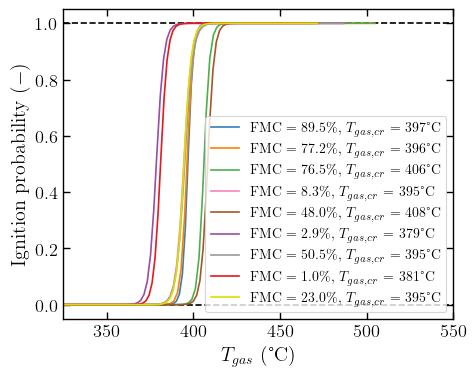

In [80]:
# Define a colorblind-friendly palette
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

# Create the scatter plot
fig, ax = plt.subplots(figsize=(5, 4))  

# Get unique values of fmc_p
unique_fmc_p = df_2['fmc_p'].unique()

TC_mine = []

for idx, fmc_p in enumerate(unique_fmc_p):
    subset = df_2[df_2['fmc_p'] == fmc_p]
    
    X = subset[['TC_corrected']]  # Features
    y = binarize(subset[['ig_prob']], threshold=0.5).ravel()
    
    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X, y)
    
    # Predict probabilities for the 'TC' values
    X_pred = pd.DataFrame(np.linspace(300, max(subset['TC_corrected']), 100),columns=['TC_corrected'])
    y_pred_proba = model.predict_proba(X_pred)[:, 1]
    
    # Find 'TC' value when logistic regression probability is 0.5
    threshold = 0.5
    log_odds_threshold = np.log(threshold / (1 - threshold))
    TC2_threshold = (log_odds_threshold - model.intercept_) / model.coef_[0][0]
    TC2_threshold_value = TC2_threshold[0]
    TC_mine.append(TC2_threshold_value)
    
    # Plot logistic regression curve
    ax.plot(X_pred, y_pred_proba, color=colors[idx], label=rf'FMC = {fmc_p:.1f}\%, $T_{{gas,cr}}$ = {TC2_threshold_value:.0f}°C')
    
# Adding labels and title
ax.set_xlabel('$T_{gas}$ (°C)')
ax.set_ylabel(r'Ignition probability ($-$)')
ax.legend(loc='best', fontsize=10)  # Adjust font size for better fit
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax.set_xlim(325,550)
ax.axhline(y=0, color='k', linestyle='--', zorder=-1)
ax.axhline(y=1, color='k', linestyle='--', zorder=-1)

plt.tight_layout()
# save_path_pdf = os.path.join(results_folder, "log_regressions_MULTIPLE.pdf" )
# plt.savefig(save_path_pdf, bbox_inches='tight')  
plt.show()

In [74]:
dfx = pd.DataFrame({
    'fmc_p': unique_fmc_p,
    'TC_gas_cr': TC_mine
})
dfx = dfx.sort_values('fmc_p').reset_index(drop=True)
dfx.head()

,fmc_p,TC_gas_cr
0,0.958888,381.159414
1,2.886505,378.701016
2,8.338154,394.516216
3,23.047925,394.639007
4,47.964331,408.311329


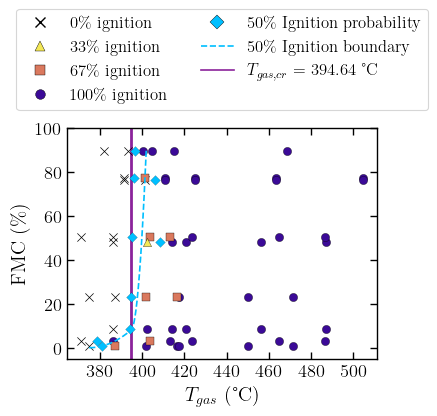

In [81]:
import warnings
from numpy.polynomial.polyutils import RankWarning

u = df_2['ig_prob'].unique()

# my_col = [100%, 66.7%, 33%]
my_col = ['#3b0a97', '#da795e', '#f4e855']

# Define specific colors for the unique ignition probabilities
colors = {0.0: 'k', u[1]: my_col[0], u[2]: my_col[1], u[3]: my_col[2]}
markers = ['o', 's', '^']
# Create the plot
fig, ax = plt.subplots(figsize=(4, 3)) 

# Separate data points with ig_prob == 0 and others
mask_ig_prob_zero = df_2['ig_prob'] == 0
mask_ig_prob_non_zero = ~mask_ig_prob_zero

# Plot data with ig_prob == 0 using 'x' marker
ax.scatter(df_2.loc[mask_ig_prob_zero, 'TC_corrected'], df_2.loc[mask_ig_prob_zero, 'fmc_p'], 
           color='k', marker='x', s=35, linewidths=0.5, label='Ignition probability = 0')

for i, (prob, color) in enumerate(colors.items()):
    if prob != 0:  # Skip the 0% ignition probability
        ax.scatter(df_2[df_2['ig_prob'] == prob]['TC_corrected'], 
                   df_2[df_2['ig_prob'] == prob]['fmc_p'], 
                   color=color, marker=markers[i - 1], s=35, edgecolor='k', linewidths=0.25, 
                   label=f'Ignition probability = {prob:.1f}')

# Scatter plot for dfx (from previous analysis!)
ax.scatter(dfx['TC_gas_cr'], dfx['fmc_p'], color='deepskyblue', marker='D', s=25, edgecolor='k', linewidths=0.1, label=r'50\% ignition probability')

ax.xaxis.set_major_locator(MultipleLocator(20))

# Add labels and title
ax.set_xlabel('$T_{gas}$ (°C)')
ax.set_ylabel(r'FMC (\%)')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax.set_ylim(-5, 100)

# Define your two points
x = np.array([375, 396])
y = np.array([0, 9])

x2 = np.array([394, 402])
y2 = np.array([9, 90])

# Fit a polynomial of degree 2 for a quadratic curve
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RankWarning)
    coeffs = Polynomial.fit(x, y, deg=2).convert().coef
    p = Polynomial(coeffs)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RankWarning)
    coeffs2 = Polynomial.fit(x2, y2, deg=2).convert().coef
    p2 = Polynomial(coeffs2)

# Generate smooth x values and compute corresponding y values
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = p(x_smooth)

x_smooth2 = np.linspace(x2.min(), x2.max(), 300)
y_smooth2 = p2(x_smooth2)

# Plot the curve
ax.plot(x_smooth, y_smooth, linestyle = '--',color = 'deepskyblue')
ax.plot(x_smooth2, y_smooth2, linestyle = '--',color = 'deepskyblue')

T_crit = 394.64
col = '#8b239b'
ax.axvline(x=T_crit, color=col, linestyle='-', linewidth = 2, zorder = -50)

# Create custom legend handles
legend_handles = [
    Line2D([0], [0], marker='x', color='k', linestyle='None', markersize=7, linewidth=0.2, label=r'0\% ignition'),
    Line2D([0], [0], marker='^', color= my_col[2], linestyle='None', markeredgecolor='k',markeredgewidth=0.3, markersize=7, label=r'33\% ignition'),
    Line2D([0], [0], marker='s', color= my_col[1], linestyle='None', markeredgecolor='k',markeredgewidth=0.3, markersize=7, label=r'67\% ignition'),
    Line2D([0], [0], marker='o', color= my_col[0], linestyle='None', markeredgecolor='k',markeredgewidth=0.3, markersize=7, label=r'100\% ignition'),
    Line2D([0], [0], marker='D', color='deepskyblue', linestyle='None', markeredgecolor='k',markeredgewidth=0.3, markersize=7, label=r'50\% Ignition probability'),
    Line2D([0], [0], marker=None, color='deepskyblue', linestyle='--',  label=r'50\% Ignition boundary'),
    Line2D([0], [0], marker=None, color=col, linestyle='-',  label=rf'$T_{{gas,cr}}={T_crit:.2f}~$°C')
]

# Add the legend to the plot
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.55), 
          fontsize=12, ncol=2, frameon=True)

# Save the plot
save_path_pdf = os.path.join(results_folder, "FMC_vs_Tgas_tig.pdf" )
plt.savefig(save_path_pdf, bbox_inches='tight')  
plt.show()